In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib
import pandas as pd
import os
import re
from tqdm import tqdm

color_array=np.linspace(0,1,11)
cmap = plt.cm.tab20b

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the notebook wider
plt.style.use('default')

In [16]:
sim_time=1000
time_step_calc = 0.2
n_iter = sim_time/time_step_calc
step_time_out = 10/time_step_calc #out every step for now
time = np.linspace(start=0, stop= n_iter*time_step_calc - step_time_out*time_step_calc, num= (int) (n_iter/step_time_out))

In [17]:
print(time)

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410.
 420. 430. 440. 450. 460. 470. 480. 490. 500. 510. 520. 530. 540. 550.
 560. 570. 580. 590. 600. 610. 620. 630. 640. 650. 660. 670. 680. 690.
 700. 710. 720. 730. 740. 750. 760. 770. 780. 790. 800. 810. 820. 830.
 840. 850. 860. 870. 880. 890. 900. 910. 920. 930. 940. 950. 960. 970.
 980. 990.]


In [9]:
qnop5_data_r15= np.loadtxt('/Users/kevinhbhimani/Desktop/siggen_ccd/waveforms/5000.00_keV/grid_0.0200/self_repulsion_1/P42575A/q=-0.10/signal_r=15.00_phi=0.00_z=0.10.txt')


In [36]:
index_cut = (int)((time_step_calc*n_iter)/step_time_out)

q0_data_old_r15 = np.loadtxt('/Users/kevinhbhimani/Desktop/siggen_sims/CPU_version/icpc_siggen/Signals/2D_comparision/test/signal_r=15.00_phi=0.00_z=0.10.txt')

n_iter = 4000
time_step_calc = 0.2
step_time_out = 10

time_old = np.linspace(start=0, stop=n_iter-1, num=n_iter)
index_cut = (int)((time_step_calc*n_iter)/step_time_out)


In [37]:
print(len(q0_data_old_r15))
print(time_old)

4000
[0.000e+00 1.000e+00 2.000e+00 ... 3.997e+03 3.998e+03 3.999e+03]


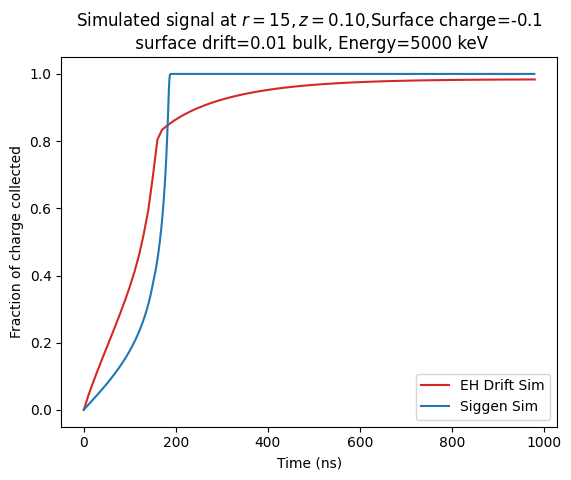

In [49]:
plt.plot(time[0:len(time)-1], qnop5_data_r15[1:],'-',markersize=2,color='tab:red')
plt.plot(time_old[0:len(q0_data_old_r15)][time_old<980], q0_data_old_r15[0:len(q0_data_old_r15)][time_old<980],'-',markersize=2,color='tab:blue')

plt.title('Simulated signal at $r=15, z=0.10$,Surface charge=-0.1\n surface drift=0.01 bulk, Energy=5000 keV')
plt.xlabel('Time (ns)')
plt.ylabel('Fraction of charge collected')
plt.legend(['EH Drift Sim', 'Siggen Sim'])
#plt.savefig('/Users/kevinhbhimani/Desktop/Thesis_proposal_figs/sims_comp.png')

plt.show()

In [6]:
q0_data_r15= np.loadtxt('/Users/kevinhbhimani/Desktop/siggen_sims/siggen_ccd_ll/waveforms/5000.00_keV/grid_0.0200/self_repulsion_1/P42575A/q=0.00/signal_r=15.00_phi=0.00_z=0.10.txt')
q0_data_old_r15 = np.loadtxt('/Users/kevinhbhimani/desktop/siggen_sims/CPU_version/icpc_siggen/Signals/2D_comparision/q=0/signal_r=15.0_phi=0.0_z=0.1.txt')
assert len(q0_data_r15)==len(time),"lengths do not match up"
# assert len(q0_data_old_r15)==len(time),"lengths do not match up"

AssertionError: lengths do not match up

ValueError: x and y must have same first dimension, but have shapes (100,) and (400,)

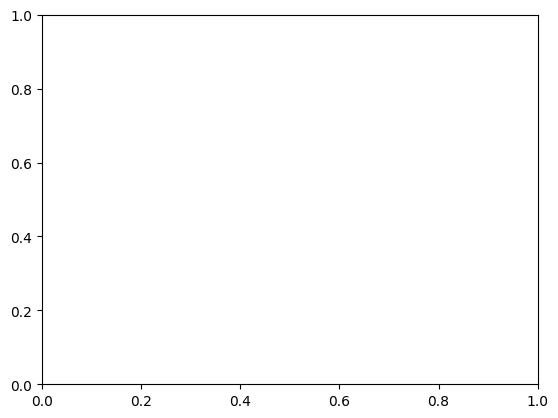

In [7]:
# time_cut_lb = 500
# time_cut_ub = 800
# plt.plot(time[(time>time_cut_lb) & (time<time_cut_ub)],q0_data_old_r15[(time>time_cut_lb) & (time<time_cut_ub)],'-',markersize=2,color='tab:blue')
# plt.plot(time[(time>time_cut_lb) & (time<time_cut_ub)],q0_data_r15[(time>time_cut_lb) & (time<time_cut_ub)],'-',markersize=2,color='tab:red')

plt.plot(time[0:len(q0_data_old_r15)],q0_data_old_r15[0:len(q0_data_old_r15)],'-',markersize=2,color='tab:blue')
plt.plot(time[0:len(q0_data_old_r15)],q0_data_r15[0:len(q0_data_old_r15)],'-',markersize=2,color='tab:red')

#plt.axvline(drift_time_50(np_data,time), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(drift_time_50(data_old,time), color='b', linestyle='dashed', linewidth=1)


plt.title('Simulated signal at $r=15, \\rho=0, z=0.1$')
plt.xlabel('Time (ns)')
plt.ylabel('Fraction of charge collected')
plt.legend(['Siggen Sim', 'EH Drift Sim'])
#plt.savefig('/Users/kevinhbhimani/Desktop/Thesis_proposal_figs/sims_comp.png')

plt.show()

In [152]:
directory = '/Users/kevinhbhimani/Desktop/siggen_sims/siggen_ccd_ll/waveforms'

energy=np.array([])
grid=np.array([])
sr=np.array([])
detector=np.array([])
surface_charge=np.array([])
radius=np.array([])
height=np.array([])
phi=np.array([])
charge_data = np.empty((0,len(time)),dtype=float)
for filename in tqdm(os.listdir(directory)):
    if('_keV' in filename):
        energy_val = filename.split("_")[0]
        for filename_g in (os.listdir(directory + '/' + filename)):
            if('grid' in directory + '/' + filename_g):
                grid_val = filename_g.split("_")[1]
                for filename_e in (os.listdir(directory + '/' + filename + '/' + filename_g)):
                    if('self_repulsion' in filename_e):
                        sr_val = filename_e.split("_")[2]
                        for filename_sr in (os.listdir(directory + '/' + filename + '/' + filename_g + '/' + filename_e)):
                            if (filename_sr.startswith('.')) == False:
                                det_val = filename_sr
                                for filename_det in (os.listdir(directory + '/' + filename + '/' + filename_g + '/' + filename_e + '/' + filename_sr)):
                                    if ('q=' in filename_det):
                                        q_val = filename_det.split("=")[1]
                                        for filename_q in (os.listdir(directory+'/'+filename+'/'+ filename_g+'/'+filename_e+'/'+filename_sr+'/'+filename_det)):
                                            if('signal_' in filename_q):
                                                data = np.loadtxt(directory+'/'+filename+'/'+filename_g+'/'+filename_e+'/'+filename_sr+'/'+filename_det+'/'+ filename_q)
    
                                                if(len(data)==len(time)):
                                                    r_val = filename_q.split("_")[1].split("=")[1]
                                                    phi_val = filename_q.split("_")[2].split("=")[1]
                                                    z_temp = filename_q.split("_")[3].split("=")[1].split(".")
                                                    z_val = z_temp[0]+"."+z_temp[1]
                                                    energy = np.append(energy, float(energy_val))
                                                    grid = np.append(grid,float(grid_val))
                                                    radius = np.append(radius, float(r_val))
                                                    height = np.append(height, float(z_val))
                                                    phi = np.append(phi, float(phi_val))
                                                    sr = np.append(sr, float(sr_val))
                                                    surface_charge = np.append(surface_charge, float(q_val))
                                                    charge_data = np.vstack([charge_data, data])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 185.21it/s]


In [153]:
print(surface_charge)

[ 0.   0.  -0.5  0.   0.  -0.5  0.  -0.5  0.  -0.5  0.   0.  -0.5  0.
  0.  -0.5  0.   0.  -0.5  0.   0.  -0.5  0.   0.  -0.5  0.   0.  -0.5
  0.   0.  -0.5  0.   0.  -0.5  0.   0.  -0.5  0.   0.  -0.5  0.   0.
 -0.5  0.  -0.5  0.  -0.5  0.  -0.5  0.  -0.5  0.   0.  -0.5  0.   0.
 -0.5  0.   0.  -0.5  0.   0.  -0.5  0.  -0.5  0.   0.  -0.5  0.   0.
 -0.5  0.   0.  -0.5  0.   0.  -0.5  0.   0.  -0.5  0.   0.  -0.5  0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5
 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.  -0.5  0.   0.  -0.5  0.   0.  -0.5  0.   0.
 -0.5  0.  -0.

In [154]:
cut = (radius==15)&(sr==1)&(height==0.02)&(grid==0.0200)

In [155]:
print(surface_charge[cut&(energy==2000)&(surface_charge==-0.5)])

[-0.5]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 11605.07it/s]


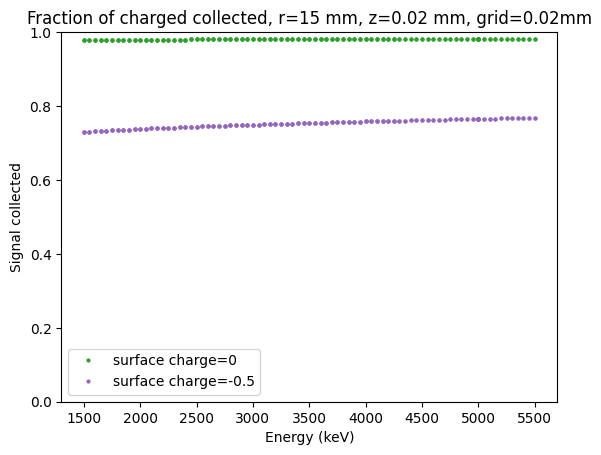

In [157]:
eng_sc_0=np.array([])
plot_e_sc_0=np.array([])
plot_e_sc_n0p5=np.array([])
plot_e_sc_p0p5=np.array([])
eng_sc_n0p5=np.array([])
eng_sc_p0p5=np.array([])
# surface_charge_vars=np.array([0 ,-0.5, 0.5])
# for sc_var in tqdm(surface_charge_vars):


    #                 plot_e_sc_n0p5=np.append(plot_e_sc_n0p5,charge_data[cut&(energy==eng)&(surface_charge==-0.5)][0][len(time)-1])
        #         plot_e_sc_p0p5=np.append(plot_e_sc_p0p5,charge_data[cut&(energy==eng)&(surface_charge==0.5)][0][len(time)-1])
index=0       
for eng in tqdm(energy):
        try:
            plot_e_sc_0=np.append(plot_e_sc_0,charge_data[cut&(energy==eng)&(surface_charge==0)][0][len(time)-1])
            eng_sc_0=np.append(eng_sc_0,eng)
        except IndexError:
            continue
            try:
                plot_e_sc_p0p5=np.append(plot_e_sc_p0p5,charge_data[cut&(energy==eng)&(surface_charge==0.5)][0][len(time)-1])
                eng_sc_p0p5=np.append(eng_sc_p0p5,eng)
            except IndexError:
                continue
        try:
            plot_e_sc_n0p5=np.append(plot_e_sc_n0p5,charge_data[cut&(energy==eng)&(surface_charge==-0.5)][0][len(time)-1])
            eng_sc_n0p5=np.append(eng_sc_n0p5,eng)
        except IndexError:
            continue
plt.plot(eng_sc_0, plot_e_sc_0,'o',markersize=2, color='tab:green')
plt.plot(eng_sc_n0p5, plot_e_sc_n0p5,'o',markersize=2, color='tab:purple')
plt.plot(eng_sc_p0p5, plot_e_sc_p0p5,'o',markersize=2, color='tab:orange')

plt.ylabel('Signal collected')
plt.xlabel('Energy (keV)')
plt.ylim(0,1)
plt.legend(['surface charge=0', 'surface charge=-0.5'])
plt.title('Fraction of charged collected, r=15 mm, z=0.02 mm, grid=0.02mm')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 9402.02it/s]


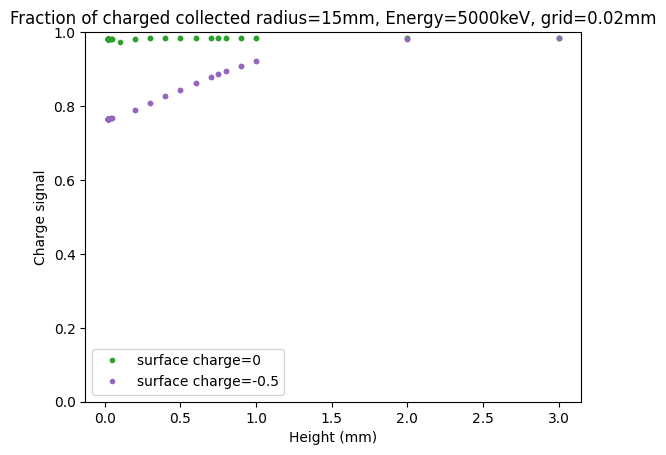

In [159]:
z_sc0=np.array([])
z_scp0p5=np.array([])
z_scnop5=np.array([])
plot_z_sco=np.array([])
plot_z_scp0p5=np.array([])
plot_z_scn0p5=np.array([])

for z in tqdm(height):
    cut = (radius==15.00)&(sr==1)&(height==z)&(grid==0.02)&(energy==5000.00)
    try:
        plot_z_sco=np.append(plot_z_sco,charge_data[cut&(surface_charge==0)][0][len(time)-1])
        z_sc0=np.append(z_sc0,z)
    except IndexError:
        continue
    try:
        plot_z_scn0p5=np.append(plot_z_scn0p5,charge_data[cut&(surface_charge==-0.5)][0][len(time)-1])
        z_scnop5=np.append(z_scnop5,z)
    except IndexError:
        continue
    try:
        plot_z_scp0p5=np.append(plot_z_scp0p5,charge_data[cut&(surface_charge==0.5)][0][len(time)-1])
        z_scp0p5=np.append(z_scp0p5,z)
    except IndexError:
        continue



plt.plot(z_sc0, plot_z_sco,'o',markersize=3, color="tab:green")#could use color=plt.cm.jet(z/max(height))
plt.plot(z_scnop5, plot_z_scn0p5,'o',markersize=3, color="tab:purple")#could use color=plt.cm.jet(z/max(height))

plt.ylabel('Charge signal')
plt.xlabel('Height (mm)')
plt.ylim(0,1)

# plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title('Fraction of charged collected radius=15mm, Energy=5000keV, grid=0.02mm')
plt.legend(['surface charge=0', 'surface charge=-0.5'])
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 9564.40it/s]


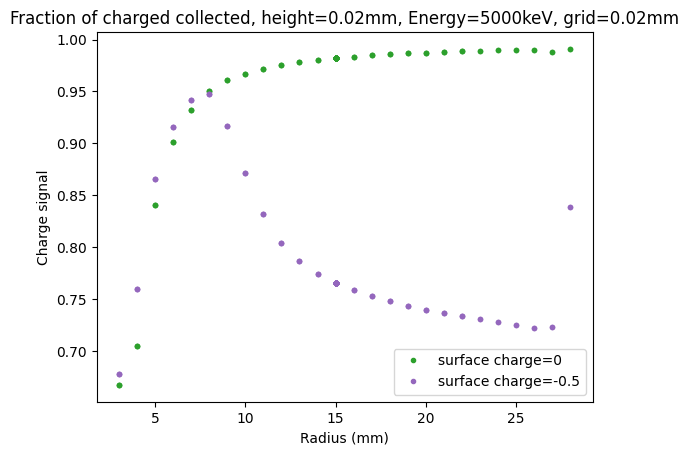

In [160]:
r_sc0=np.array([])
r_scp0p5=np.array([])
r_scn0p5=np.array([])
plot_r_sco=np.array([])
plot_r_scp0p5=np.array([])
plot_r_scn0p5=np.array([])

for r in tqdm(radius):
    cut = (height==0.02)&(sr==1)&(radius==r)&(grid==0.02)&(energy==5000.00)
    try:
        plot_r_sco=np.append(plot_r_sco,charge_data[cut&(surface_charge==0)][0][len(time)-1])
        r_sc0=np.append(r_sc0,r)
    except IndexError:
        continue
    try:
        plot_r_scn0p5=np.append(plot_r_scn0p5,charge_data[cut&(surface_charge==-0.50)][0][len(time)-1])
        r_scn0p5=np.append(r_scn0p5,r)
    except IndexError:
        continue
    try:
        plot_r_scp0p5=np.append(plot_r_scp0p5,charge_data[cut&(surface_charge==0.50)][0][len(time)-1])
        r_scp0p5=np.append(r_scp0p5,r)
    except IndexError:
        continue
    
    

plt.plot(r_sc0, plot_r_sco,'o',markersize=3, color="tab:green")
plt.plot(r_scn0p5, plot_r_scn0p5,'o',markersize=3, color="tab:purple")
# plt.plot(r_scp0p5, plot_r_scp0p5,'o',markersize=5, color="tab:blue")

plt.ylabel('Charge signal')
plt.xlabel('Radius (mm)')
# plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title('Fraction of charged collected, height=0.02mm, Energy=5000keV, grid=0.02mm')
plt.legend(['surface charge=0', 'surface charge=-0.5'])

plt.show()

In [109]:
r_plot = np.array([])
z_plot = np.array([])
eng_plot = np.array([])
eng_use = 5000

In [110]:
for r in tqdm(radius[0::10]):
    for z in height[0::10]:
        cut = (height==z)&(sr==1)&(radius==r)&(grid==0.02)&(energy==eng_use)
        try:
            pick_off = charge_data[cut][0][len(time)-1]
            r_plot = np.append(r_plot, r)
            z_plot = np.append(z_plot, z)
            eng_plot = np.append(eng_plot, pick_off)
            #plt.plot(radius[cut], height[cut],'o', color=plt.cm.jet(pick_off))
        except IndexError:
#             print("Point skipped:(", r,",", z,")")
            continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 876.92it/s]


In [87]:
from  pygama.dsp.processors.trap_filters import trap_filter
from  pygama.dsp.processors.trap_filters import trap_norm

sim_time=11000
time_step_calc = 0.2
n_iter = sim_time/time_step_calc
step_time_out = 1 #out every step for now
time = np.linspace(start=0, stop= n_iter*time_step_calc - step_time_out*time_step_calc, num= (int) (n_iter/step_time_out))

trap_in = np.loadtxt('/Users/kevinhbhimani/Desktop/siggen_ccd/waveforms/5000.00_keV/grid_0.0200/self_repulsion_1/P42575A/q=0.00/signal_r=15.00_phi=0.00_z=0.10.txt')
assert len(trap_in) == len(time)

plt.plot(time,trap_in)
plt.ylabel('Charge signal')
plt.xlabel('Time (ns)')
# plt.legend(['with self-repulsion', 'without self-repulsion'])
# plt.title('Max energy using SR - max energy without SR at radius=25.00')
# plt.legend(['z=0.05','z=0.10','z=0.15','z=0.20','z=0.50','z=1.00','z=2.00','z=3.00','z=5.00','z=10.00'])

# rise time of 4 us and a flat top of 2.5 us. We pick off the energy at 6 us from the start time
# Parameters
# w_in (ndarray) -- the input waveform.

# rise (int) -- the number of samples averaged in the rise and fall sections.

# flat (int) -- the delay between the rise and fall sections.

# w_out (ndarray) -- the filtered waveform
rise_time = 4000 #ns
flat_top = 2500 #ns
pickup = 6000 #ns
trap_out = np.zeros(len(trap_in))
trap_norm(trap_in, int(rise_time/time_step_calc), int(flat_top/time_step_calc), trap_out)

plt.plot(time,trap_in)
plt.plot(time,trap_out)
plt.axvline(x=pickup, color='r')
print("energy collected at pickup", trap_out[(int)(pickup/time_step_calc)])
plt.ylabel('Charge signal')
plt.xlabel('Time (ns)')
plt.legend(['Waveform','Trap out', 'pick off'])
plt.title('Event with Energy = 5000 keV at $r=15.00$ mm, $r=0.10$ mm')

ModuleNotFoundError: No module named 'pygama'

In [ ]:
# index=0
# for r in tqdm(range(0,len(z_plot))):
#     plt.plot(r[index], z[index],'o', color=plt.cm.jet(eng_plot[index]))
#     index = index + 1
# plt.ylabel('Height (mm)')
# plt.xlabel('Radius (mm)')
# # plt.legend(['with self-repulsion', 'without self-repulsion'])
# plt.title('Fraction of charged collected, Energy=50.00 keV')
# plt.show()

In [ ]:
plt.scatter(r_plot[0:len(z_plot)],z_plot, c=eng_plot, cmap='summer_r') #_r reverses the colormap
plt.ylabel('Height (mm)')
plt.xlabel('Radius (mm)')
# plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title(f'Fraction of charged collected, Energy={eng_use}keV')
plt.colorbar()
plt.show()

In [ ]:
r_use = 15
eng_use = 5000
for z in height:
    cut = (height==z)&(sr==1)&(radius==r_use)&(grid==0.02)&(energy==eng_use)
    pick_off = charge_data[cut][0][len(time)-1]
    plt.plot(z, pick_off, 'o', color='tab:purple')
plt.ylabel('Fraction of charge collected (mm)')
plt.xlabel('Height (mm)')
# plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title(f'Fraction of charged collected, radius={r_use}, Energy={eng_use}keV')
plt.show()

In [ ]:
z_use = 0.05
eng_use = 800
for r in radius:
    try:
        cut = (radius==r)&(sr==1)&(height==z_use)&(grid==0.02)&(energy==eng_use)
        pick_off = charge_data[cut][0][len(time)-1]
        plt.plot(r, pick_off, 'o', color='tab:green')
    except IndexError:
        continue
plt.ylabel('Fraction of charge collected (mm)')
plt.xlabel('Radius (mm)')
# plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title(f'Fraction of charged collected, height={z_use}, Energy={eng_use}keV')
plt.show()